## Imports

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numba as nb
from numba import jit

In [2]:
import os

In [3]:
from sklearn.cluster import KMeans

In [4]:
import pickle

In [5]:
import pyfftw

## Read in data

In [6]:
s = os.stat('Run_00120_00.bin')

In [7]:
N = int((s.st_size - 8)/7033)

In [8]:
dh = np.dtype([
    ('result',np.ubyte), ('event id', 'i'), 
    ('board number', 'i4'), ('channel number', 'i4'),
    ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
    ('length', 'i4')])

In [9]:
dt = np.dtype([('header', dh), ('wf', '3500h')])

In [10]:
with open('Run_00120_00.bin', 'rb') as file:
    theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
    file.seek(8)
    data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')

### bit logic, shuffling - this is to prevent some sort of bias from selecting data in one portion of the data

In [11]:
@jit(nopython=True)
def bitLogic(x):
    for i in range(3500):
        x[i] &= 16383
        if x[i]>8191:
            x[i] -= 16384

In [12]:
for j in range(N):
    bitLogic(data['wf'][j])

In [13]:
@jit(nopython=True)
def scramble(x):
    np.random.shuffle(x)

In [14]:
scramble(data['wf'][:10])
scramble(data['wf'])

In [15]:
data['wf'].shape

(429600, 3500)

### normalizing -1 to 1 --- save scaling factors to be able to reconstruct waveforms

In [16]:
@jit(nopython=True)
def normBatch(data):
    x = data.astype(np.float32)
    y = np.empty((len(data),2))
    for i in range(len(data)):
        y[i,0] = np.amin(x[i])
        x[i] = x[i] - y[i,0]
        y[i,1] = np.amax(x[i])
        x[i] = x[i]*2./y[i,1]
        x[i] = x[i] - 1
    return x, y

In [17]:
X,y = normBatch(data['wf'][:10])
X,y = normBatch(data['wf'])

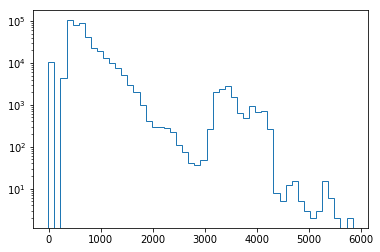

In [18]:
plt.hist(y[:,1]-y[:,0], bins=50, histtype='step');
plt.yscale('log')

While in previous applications, I cared about what was going on with the noise, now I'm going to cut off a lot of the noise so that I can only look at things that would really fuck up the data stream

In [19]:
X, y = X[(y[:,1]-y[:,0])>2000], y[(y[:,1]-y[:,0])>2000]

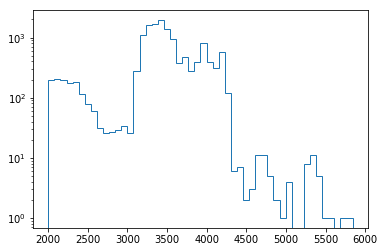

In [20]:
plt.hist(y[:,1]-y[:,0], bins=50, histtype='step');
plt.yscale('log')

# K means clustering

### How many clusters should I use?

In [21]:
maxClusters = 5
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = KMeans(n_clusters=numClusters, n_jobs=2).fit(X[:10**4])
    res2[numClusters-2] = kmean.score(X[:10**4])

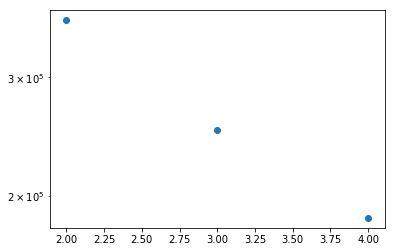

In [22]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

In [23]:
kmean = KMeans(n_clusters=3, n_init=25, n_jobs=3)

In [24]:
kmean.fit(X);

In [25]:
clusterIDs = kmean.labels_

In [26]:
clusterE = [np.array([y[j,1]-y[j,0] for j in range(len(X)) if clusterIDs[j]==i]) for i in range(kmean.cluster_centers_.shape[0])]

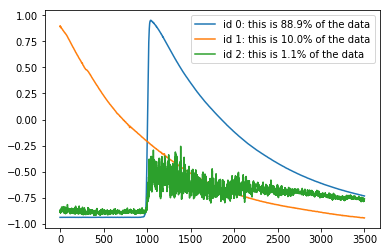

In [73]:
#fig = figure(figsize=(25,10))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(np.around(100*len(clusterE[i])/len(X),1))+'% of the data')
legend();

In [74]:
X = X[kmean.labels_==0]

# SVM outlier detection

In [77]:
from sklearn.svm import OneClassSVM

In [88]:
svm = OneClassSVM(nu=.01, gamma='scale')

In [89]:
clf = svm.fit(X)

In [90]:
scores = clf.predict(X)

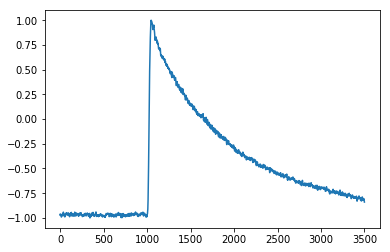

In [136]:
plt.plot(X[scores==-1][35]);

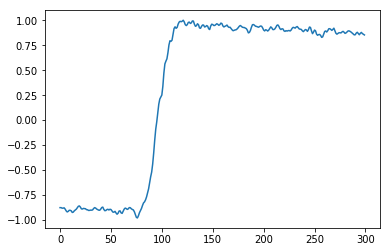

In [129]:
plt.plot(X[scores==-1][28,900:1200]);

# Local Outlier Factor

In [137]:
from sklearn.neighbors import LocalOutlierFactor

In [138]:
Lof = LocalOutlierFactor(n_neighbors=5, contamination=.01)

In [139]:
y_pred = Lof.fit_predict(X)

In [140]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

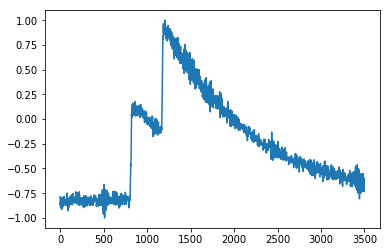

In [144]:
plt.plot(X[y_pred==-1][2]);

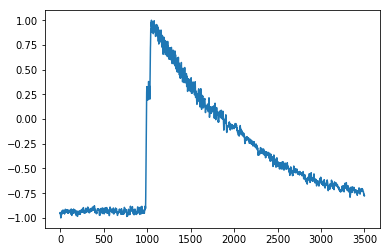

In [148]:
plt.plot(X[y_pred==-1][6]);

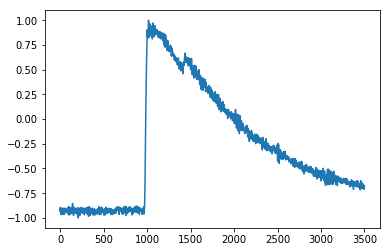

In [151]:
plt.plot(X[y_pred==-1][9]);

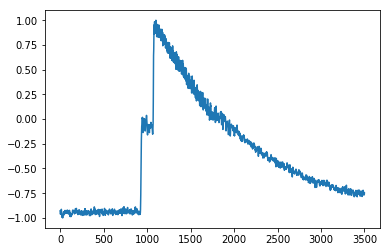

In [153]:
plt.plot(X[y_pred==-1][11]);

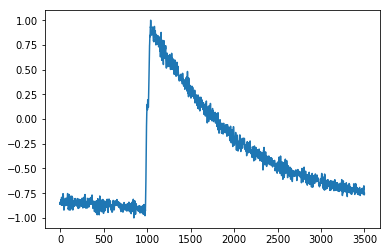

In [156]:
plt.plot(X[y_pred==-1][14]);

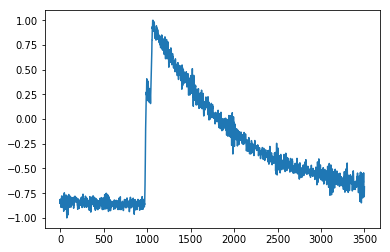

In [168]:
plt.plot(X[y_pred==-1][26]);

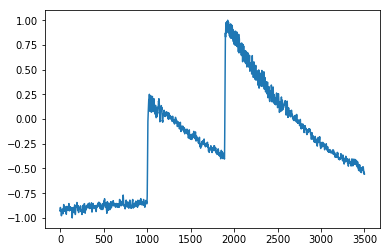

In [197]:
plt.plot(X[y_pred==-1][50]);

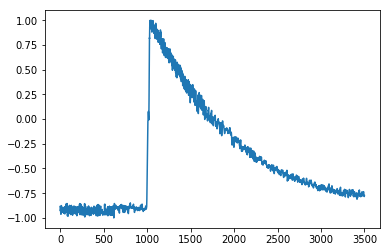

In [205]:
plt.plot(X[y_pred==-1][58]);

In [212]:
pileups = [2, 6, 9, 11, 14, 26, 50, 58]

In [227]:
p_ids = []

In [228]:
count = 0
for i in range(len(y_pred)):
    if y_pred[i]==-1:
        if count in pileups:
            p_ids.append(i)
            plt.plot(X[i])
            plt.savefig(str(count)+'.png')
            plt.close()
        count +=1

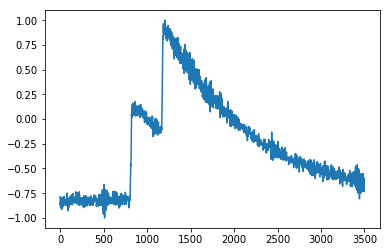

In [218]:
plt.plot(X[369])

In [229]:
np.save('pileup_X.npy',X[p_ids])

# Isolation Forest

In [252]:
from sklearn.ensemble import IsolationForest

In [269]:
isf = IsolationForest(contamination=0.01, behaviour='new')

In [270]:
y_pred = isf.fit_predict(X)

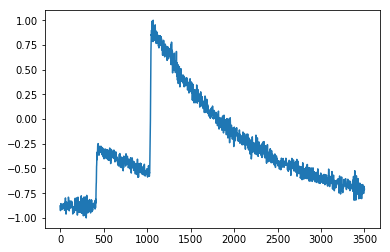

In [344]:
plt.plot(X[y_pred==-1][-14]);
plt.savefig('isf.png')

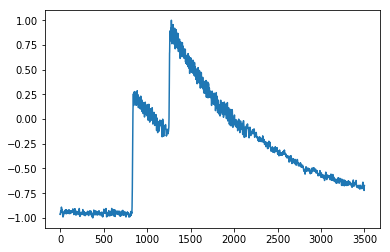

In [345]:
plt.plot(X[y_pred==-1][-40]);
plt.savefig('isf2.png')

In [346]:
new_pileups = [-14,-40]

In [347]:
new_p_ids = []

In [348]:
count = 0
for i in range(len(y_pred)):
    if y_pred[i]==-1:
        if count in pileups:
            new_p_ids.append(i)
        count +=1

In [349]:
np.save('pileup_X2.npy',X[new_p_ids])

# Fast ICA

In [234]:
from sklearn.decomposition import FastICA

In [247]:
# Comsklearn ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X[p_ids])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [248]:
S_.shape

(8, 2)

In [250]:
A_.shape

(3500, 2)

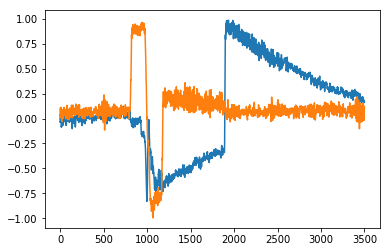

In [251]:
for x in A_.T:
    plt.plot(x)

In [238]:
A_.shape

(3500, 3)